In [1]:
# Imports
import torch
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import pygame
import random
import tqdm

In [2]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class snake_ExperienceBuffer:
    def __init__(self, capacity, map_size):

        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 4), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 4), dtype=torch.float)

        # total samples collected
        self.occupied = 0

        self.cap = capacity

    
    def push(self, state, action, reward, next_state, done):  
        
        if self.occupied < self.cap:
            index = self.occupied
        else:
            # after being filled replacing randomly
            index = np.random.randint(low =0, high=self.occupied)

        self.buffer[index][0] = reward
        self.buffer[index][1] = done

        self.actions[index] = action
        self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
        
        self.occupied += 1
        self.occupied = min(self.occupied, self.cap)

    def sample(self, batch_size):

        batch = torch.randint(0, self.occupied, size=(batch_size,))

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):
        
        return self.occupied >= batch 



In [230]:
class SnakeGame(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, size=10, render_mode=None):
        super().__init__()
        self.size = size
        self.cell_size = 30
        self.screen_size = self.size * self.cell_size
        self.render_mode = render_mode

        self.action_space = gym.spaces.Discrete(4)  # 0: right, 1: up, 2: left, 3: down
        # self.observation_space = gym.spaces.Box(-1, 1, shape=(self.size+2, self.size+2), dtype=np.float32)
        self.observation_space = gym.spaces.Box(-1, 1, shape=(4,), dtype=np.float32)

        self.screen = None
        self.clock = None

        self.snake = deque()

        self.data = []


        #####
        mid = self.size // 2
        self.snake.appendleft([mid, mid])
        self.direction = [1, 0]
        self.food = None
        self._place_food()
        #####

        
        if self.render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.snake.clear()
        mid = self.size // 2
        self.direction = [1, 0]
        self.snake.appendleft([np.random.randint(low=1, high=self.size), np.random.randint(low=1, high=self.size)])
        self._place_food()
        obs = self._get_obs()

        if self.render_mode == "human":
            self._render_init()

        return obs, {}
    

    def step(self, action):
        # TODO: Change reward schema to avoid the following
        # 1) 180 degree turns
        # 2) Wall collisions
        # 3) Being slow at collecting food

        reward = 0

        if action == 0:
            if self.direction != [-1, 0] or len(self.snake) == 1: 
                self.direction = [1, 0]
            else:
                reward -= 100
        elif action == 1:
            if self.direction != [0, 1] or len(self.snake) == 1: 
                self.direction = [0, -1]
            else:
                reward -= 100
        elif action == 2:
            if self.direction != [1, 0] or len(self.snake) == 1: 
                self.direction = [-1, 0]
            else:
                reward -= 100
        elif action == 3:
            if self.direction != [0, -1] or len(self.snake) == 1: 
                self.direction = [0, 1]
            else:
                reward -= 100


        # if action == 0 and self.direction != [-1, 0]: self.direction = [1, 0]
        # elif action == 1 and self.direction != [0, 1]: self.direction = [0, -1]
        # elif action == 2 and self.direction != [1, 0]: self.direction = [-1, 0]
        # elif action == 3 and self.direction != [0, -1]: self.direction = [0, 1]

        

        head = self.snake[0]
        new_head = [head[0] + self.direction[0], head[1] + self.direction[1]]

        done = False

        if not (0 <= new_head[0] < self.size and 0 <= new_head[1] < self.size):
            done = True
        else:
            body_to_check = list(self.snake)[:-1] if new_head != self.food else list(self.snake)
            if new_head in body_to_check:
                done = True

        # Calculate distance to food before and after the move
        old_dist = abs(head[0] - self.food[0]) + abs(head[1] - self.food[1])
        new_dist = abs(new_head[0] - self.food[0]) + abs(new_head[1] - self.food[1])


        if new_head == self.food:
            reward += 200  # food reward
        elif done:
            reward += -200  # death
        else:
            reward += (old_dist - new_dist) * 100  # Reward moving toward food
            reward -= 50 # stopping from moving in circles

        if not done:
            self.snake.appendleft(new_head)
            if new_head == self.food:
                self._place_food()
                if self.food == None:
                    done = True
            else:
                self.snake.pop() 

        obs = self._get_obs()
        # if not done:
        #     obs = self._get_obs()
        # else:
        #     obs = torch.zeros(size=(3,8,8))

        if self.render_mode == "human":
            self.render()


        return obs, reward, done, False, {}

    def _get_obs(self):
        # TODO: Return an observation state, take inspiration from the observation_space attribute

        # snakes sees what is in its front, left, right side, the angle to the food
        #  and outputs 3 actions either going straight/left/right relative to its current direction

        # this does not invovle size of the map, works on all sizes after training on any one
        
        # but this is represntation is incomplete multiple states have the same obs which breaks the property that furture states and rewards only depend on the current state and not on the past states
        # this property is required for DQN, without this performance may not be good

        # also it only tells the snake about the first thing in the line of sight and not what is beyond that

        # this will help generalize across states using symmetry to combine "diff" states into one idk if it was already happening due to cnn
        obs = torch.zeros(size=(4, ))

        # if snake is vertical
        i, j = self.snake[0][0], self.snake[0][1]
        dist = 0
        direc = self.direction[0] + self.direction[1]
        inv = 1
        food = self.food
        snake = self.snake

        # if snake is horizontal switch x, y
        if self.direction[1] == 0:
            i, j = j, i
            inv = -1
            food = [self.food[1], self.food[0]]
            snake = []
            for [l, k] in self.snake:
                snake.append([k, l])

        # the front dir
        dist = direc
        while 0 <= j + dist <  self.size:
            if [i, j + dist] == food:
                obs[1] =  1    # ## #
                break
            elif [i, j + dist] in snake:
                obs[1] = -1 + (abs(dist) - 1)/self.size     # ## #
                break
            dist += direc

        if j + dist == self.size or j+dist == -1:
            obs[1] = -1 + (abs(dist) - 1)/self.size
        
        # the sides
        
        # left
        dist = inv*direc
        while 0 <= i + dist <  self.size:
            if [i+dist, j] == food:
                obs[0] = 1     # ## #
                break
            elif [i+dist, j] in snake:
                obs[0] = -1 + (abs(dist) - 1)/self.size    # ## #
                break
            dist += inv*direc
        
        if i + dist == self.size or i + dist == -1:
            obs[0] = -1 + (abs(dist) - 1)/self.size

        
        # right
        dist = -inv*direc
        while 0 <= i + dist <  self.size:

            if [i+dist, j] == food:
                obs[2] = 1     # ## #
                break
            elif [i+dist, j] in snake:
                obs[2] = -1 + (abs(dist) - 1)/self.size    # ## #
                break
            dist += -inv*direc
        
        if i + dist == self.size or i + dist == -1:
            obs[2] = -1 + (abs(dist) - 1)/self.size


        vec = pygame.math.Vector2((self.food[0] - self.snake[0][0], self.food[1] - self.snake[0][1]))
        # ang = vec.angle_to(self.direction)
        ang = vec.dot(self.direction)/(vec.magnitude())
        obs[3] = ang

        #################################################################################################################################################################################################################
        
        # collecting images to try to train a cnn and then used as main obs

        obs2 = torch.zeros(size=(3, self.size, self.size))

        # for snake's body except head
        for i, j in self.snake:
            obs2[0, i, j] = 1

        # for head
        obs2[1, self.snake[0][0], self.snake[0][1]] = 1

        # food
        obs2[2, self.food[0], self.food[1]] = 1

        # self.data.append(obs2)

        return [obs2, obs]
        # return obs2

    def _place_food(self):
        positions = set(tuple(p) for p in self.snake)
        empty = [(x, y) for x in range(self.size) for y in range(self.size) if (x, y) not in positions]
        self.food = list(random.choice(empty)) if empty else None

    def render(self):
        if self.screen is None:
            self._render_init()

        self.screen.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.screen, (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )
        if self.food:
            fx, fy = self.food
            pygame.draw.rect(
                self.screen, (255, 0, 0),
                pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
            )

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def _render_init(self):
        pygame.init()
        self.screen = pygame.display.set_mode((self.size * self.cell_size, self.size * self.cell_size))
        self.clock = pygame.time.Clock()

    def close(self):
        if self.screen:
            pygame.quit()
            self.screen = None

In [4]:
# TODO: Implement training logic for Snake Game here

import copy


def train(model, epoch=1000, gamm=0.99, size=12, rend=False, lrate=0.001):

    if rend:
        env = SnakeGame(size, render_mode="human")
    else:
        env = SnakeGame(size)

    q_net = model
    target_net = copy.deepcopy(q_net)

    replay_buffer = snake_ExperienceBuffer(10000, size)
    # temp_buffer = []

    epochs = epoch
    epsilon = 1
    batch_size = 64
    gamma = gamm
    # loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=lrate)

    results = np.zeros(epochs)
    epsilons = np.zeros(epochs)

    steps_till_update = 0
    step_count = 0
    for i in tqdm.tqdm(range(epochs)):

        state = env.reset()[0]
        done = False
        total_reward = 0
        step_count = 0

        greedy = False

        # with torch.no_grad():
        #     # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
        #     action = np.argmax(target_net(state.unsqueeze(0)))
        # # next_action = 0

        rel_action = np.random.randint(0, 3)
        dire = env.direction
        if dire[1] == 0:
            action = (dire[0] - rel_action)%4
        else:
            action = (1 - dire[1] - rel_action)%4

        while not done:

            optimizer_seq.zero_grad()

            next_state, reward, done, _, _ = env.step(int(action))
            
            if (not greedy) or epsilon > 0:
                # temp_buffer.append((state, action, reward, next_state, done))
                replay_buffer.push(state, rel_action, reward, next_state, done)

            # selecting next action
            if np.random.rand() < epsilon and not torch.sum(next_state[0:3] == -1):
                rel_action = np.random.randint(0, 3)
                greedy = True
            else:
                with torch.no_grad():
                    # next_action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(next_state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
                    rel_action = np.argmax(q_net(next_state.unsqueeze(0)))
                    # print(action)
                greedy = False

            # converting the action
            # 
            # 0: right, 1: up, 2: left, 3: down 
            dire = env.direction
            if dire[1] == 0:
                action = (dire[0] - rel_action)%4
            else:
                action = (1 - dire[1] - rel_action)%4

            total_reward += reward
            steps_till_update += 1
            step_count += 1
            state = next_state

            if replay_buffer.filled(batch_size):
            
                data, actions, states, next_states = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    # next_action = torch.zeros(size=(batch_size, 1), dtype=torch.int64)
                    # for i in range(batch_size):
                    #     next_action[i, 0] = int(np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(target_net(next_states[i].unsqueeze(0)).reshape(4,), dim=0).numpy()))
                    # targets = data[:, 0] + gamma*target_net.forward(next_states).gather(1, next_actions)*(1-data[:, 1])
                    # print("target_net(next_states) shape:", target_net(next_states).shape)
                    targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

                loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10)
                optimizer_seq.step()


            # updating target net
            if steps_till_update == 100:
            # if steps_till_update == max(i, 50):
                steps_till_update = 0
                target_net = copy.deepcopy(q_net)

            if total_reward <= -1000:
                done = True

        # n = len(temp_buffer)
        # if n > 0:
        #     probs = np.arange(1, n+1)
        #     probs = probs/probs.sum()  # Normalize to sum to 1
        #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
        #         replay_buffer.push(*temp_buffer[j])

        # temp_buffer = []

        if epsilon > 0.1:
            epsilon = max(0.1, 1-i*0.9/(epoch/2))

        results[i] = total_reward
        epsilons[i] = epsilon
        total_reward = 0

    return results, epsilons, env.data


In [5]:
def plot_progress(results):
    # plt.plot(np.convolve(results, np.ones(1)/1))
    plt.plot(np.convolve(results, np.ones(50)/50, 'valid'))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    print(f"Best run: {max(results)}, at episode: {np.argmax(results)+1}")
    plt.scatter(np.argmax(results), 10, color='orange', s=100, zorder=5)

In [9]:
import time

def evaluate_model(model, size=20, episodes=10, render=True, epsil = 0, wait=False, print_qvals=False):
    env = SnakeGame(size=size, render_mode="human" if render else None)
    model.eval()

    rewards = []
    counts = []

    # time.sleep(3)
    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        rel_action = np.random.randint(low=0, high=3)
        # with torch.no_grad():
        #     q_values = model(state)
        #     action = torch.argmin(q_values, dim=1).item()
        count = 0
        steps = 0

        while not done:

            if not done:
                dire = env.direction
                if dire[1] == 0:
                    action = (dire[0] - rel_action)%4
                else:
                    action = (1 - dire[1] - rel_action)%4

                # print(f"direc {env.direction}")
                # print(f"action {action}, rel action {rel_action}")
                count = len(env.snake) - 1
                obs, reward, done, _, _ = env.step(action)
                # print("-"*10)
                total_reward += reward

            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

            # print("obs", state)
            if np.random.rand() < epsil and not torch.sum(state[0, 0:3] == -1):
                rel_action = np.random.randint(low=0, high=3)
                # print(f"explored")
            else:
                with torch.no_grad():
                    q_values = model(state)
                    if print_qvals:
                        print(q_values)
                    rel_action = torch.argmax(q_values).item()
                # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state).reshape(4,), dim=0).numpy())[0]
                # action = torch.argmax(q_values, dim=1).item()


            # np.argsort(q_values)
            # for i in range(size+2):
            #     for j in range(size+2):
            #         print(obs[0][i][j], end="")
            #     print()
            # print(obs)


            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"straight: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            # print()
            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"up: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            # print()
            
            waiting = wait
            while waiting:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_n:
                            waiting = False
                        if event.key == pygame.K_ESCAPE:
                            done = True
                            waiting = False

            steps += 1
            if steps >= 4000:
                done = True
                print("step limit of 4000 crossed")
            # print(total_reward)
            # if render:
                # env.render()
    
        rewards.append(total_reward)
        counts.append(count)
        print(f"Episode {episode + 1}: Reward = {total_reward}: Apples got:{count}")

    env.close()
    avg_reward = sum(rewards) / episodes
    avg_count = np.mean(counts)

    print(f"Average reward over {episodes} episodes: {avg_reward}")
    print(f"Average apples over {episodes} episodes: {avg_count}")
    return env.data

In [8]:
snake_QN = torch.nn.Sequential(

    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 12),
    torch.nn.ReLU(),
    torch.nn.Linear(12, 3)
)

## Testing

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3119640414.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3119640414.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [02:17<00:00,  4.36it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3780120984.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_g

Episode 1: Reward = 7050: Apples got:15
Episode 2: Reward = 7600: Apples got:15
Episode 3: Reward = -200: Apples got:0
Episode 4: Reward = 8850: Apples got:20
Episode 5: Reward = 12800: Apples got:28
Episode 6: Reward = 8000: Apples got:27
Episode 7: Reward = 12900: Apples got:25
Episode 8: Reward = 8800: Apples got:25
Episode 9: Reward = 9850: Apples got:38
Episode 10: Reward = 9600: Apples got:23
Average reward over 10 episodes: 8525.0
Average apples over 10 episodes: 21.6


100%|██████████| 600/600 [02:18<00:00,  4.32it/s]


Episode 1: Reward = 9100: Apples got:23
Episode 2: Reward = 6100: Apples got:16
Episode 3: Reward = 9000: Apples got:25
Episode 4: Reward = 7700: Apples got:18
Episode 5: Reward = 6800: Apples got:19
Episode 6: Reward = 7250: Apples got:13
Episode 7: Reward = 10200: Apples got:25
Episode 8: Reward = 7350: Apples got:16
Episode 9: Reward = 8000: Apples got:20
Episode 10: Reward = 6250: Apples got:16
Average reward over 10 episodes: 7775.0
Average apples over 10 episodes: 19.1


100%|██████████| 600/600 [04:25<00:00,  2.26it/s]


Episode 1: Reward = 12150: Apples got:32
Episode 2: Reward = 8200: Apples got:19
Episode 3: Reward = 13350: Apples got:29
Episode 4: Reward = 11050: Apples got:18
Episode 5: Reward = 7050: Apples got:16
Episode 6: Reward = 11450: Apples got:27
Episode 7: Reward = 10000: Apples got:26
Episode 8: Reward = 10000: Apples got:19
Episode 9: Reward = 5900: Apples got:15
Episode 10: Reward = 9150: Apples got:28
Average reward over 10 episodes: 9830.0
Average apples over 10 episodes: 22.9
Best run: 12100.0, at episode: 580
Best run: 14700.0, at episode: 524
Best run: 16300.0, at episode: 593


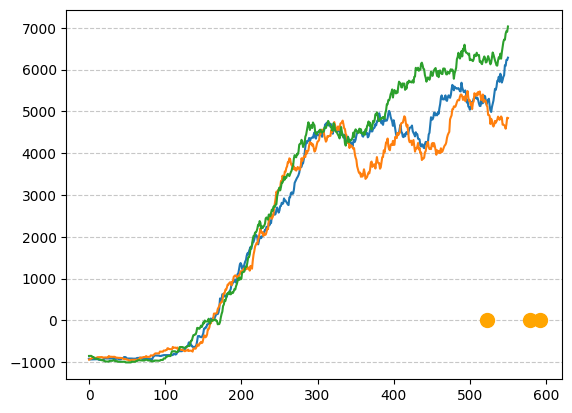

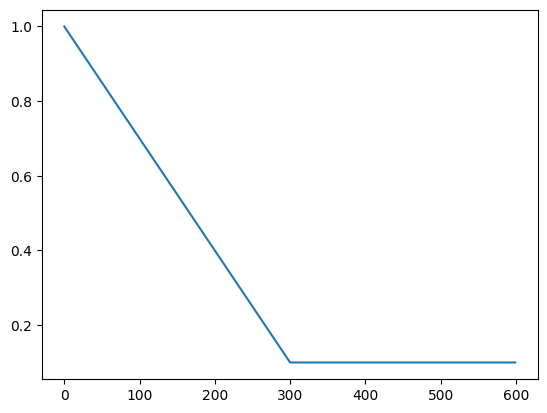

In [11]:
model = torch.nn.Sequential(    torch.nn.Linear(4, 64),    torch.nn.ReLU(),    torch.nn.Linear(64, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results1_1, epsilons1 = train(model, epoch=600, gamm=0.99, lrate=0.001)
evaluate_model(model, print_qvals=False, render=False, episodes=10, size=12)

model = torch.nn.Sequential(    torch.nn.Linear(4, 64),    torch.nn.ReLU(),    torch.nn.Linear(64, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results1_2, epsilons1 = train(model, epoch=600, gamm=0.99, lrate=0.001)
evaluate_model(model, print_qvals=False, render=False, episodes=10, size=12)

model = torch.nn.Sequential(    torch.nn.Linear(4, 64),    torch.nn.ReLU(),    torch.nn.Linear(64, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results1_3, epsilons1 = train(model, epoch=600, gamm=0.99, lrate=0.001)
evaluate_model(model, print_qvals=False, render=False, episodes=10, size=12)

plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

Same as last but 1000 epochs 

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3119640414.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3119640414.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 1000/1000 [06:47<00:00,  2.45it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3780120984.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().require

Episode 1: Reward = 8150: Apples got:31
Episode 2: Reward = 9950: Apples got:25
Episode 3: Reward = 7150: Apples got:23
Episode 4: Reward = 10100: Apples got:27
Episode 5: Reward = 12950: Apples got:25
Episode 6: Reward = 10550: Apples got:22
Episode 7: Reward = 14150: Apples got:33
Episode 8: Reward = 8300: Apples got:21
Episode 9: Reward = 9400: Apples got:21
Episode 10: Reward = 8500: Apples got:23
Average reward over 10 episodes: 9920.0
Average apples over 10 episodes: 25.1


100%|██████████| 1000/1000 [08:24<00:00,  1.98it/s]


Episode 1: Reward = 6250: Apples got:14
Episode 2: Reward = 9400: Apples got:23
Episode 3: Reward = 10250: Apples got:25
Episode 4: Reward = 8400: Apples got:17
Episode 5: Reward = 10650: Apples got:21
Episode 6: Reward = 6500: Apples got:26
Episode 7: Reward = 14500: Apples got:32
Episode 8: Reward = 12750: Apples got:34
Episode 9: Reward = 12400: Apples got:24
Episode 10: Reward = 7350: Apples got:14
Average reward over 10 episodes: 9845.0
Average apples over 10 episodes: 23.0


100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


Episode 1: Reward = 5800: Apples got:14
Episode 2: Reward = 5650: Apples got:10
Episode 3: Reward = 15750: Apples got:28
Episode 4: Reward = 4850: Apples got:11
Episode 5: Reward = 9150: Apples got:19
Episode 6: Reward = 9600: Apples got:19
Episode 7: Reward = 10750: Apples got:19
Episode 8: Reward = 7800: Apples got:22
Episode 9: Reward = 7150: Apples got:16
Episode 10: Reward = 9000: Apples got:26
Average reward over 10 episodes: 8550.0
Average apples over 10 episodes: 18.4
Best run: 12900.0, at episode: 1000
Best run: 12700.0, at episode: 835
Best run: 14950.0, at episode: 782


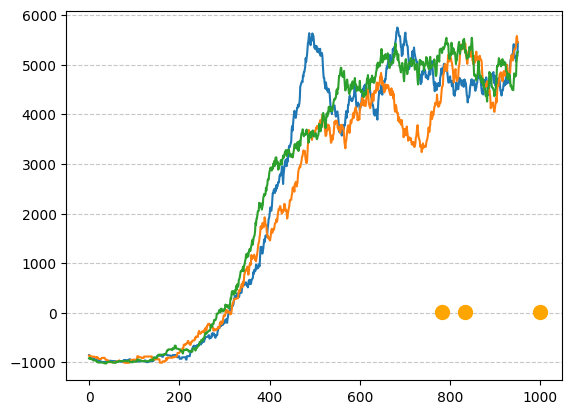

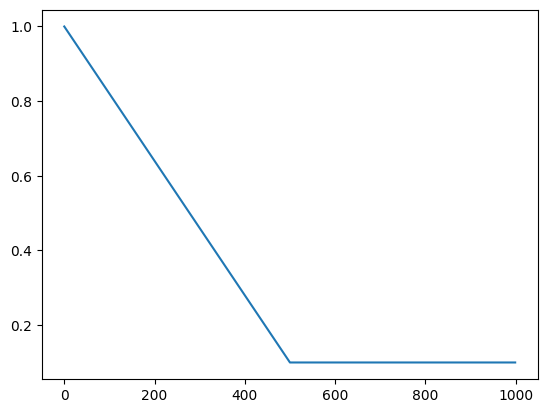

In [9]:
model = torch.nn.Sequential(    torch.nn.Linear(4, 64),    torch.nn.ReLU(),    torch.nn.Linear(64, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001)
evaluate_model(model, print_qvals=False, render=False, episodes=10, size=12)

model = torch.nn.Sequential(    torch.nn.Linear(4, 64),    torch.nn.ReLU(),    torch.nn.Linear(64, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001)
evaluate_model(model, print_qvals=False, render=False, episodes=10, size=12)

model = torch.nn.Sequential(    torch.nn.Linear(4, 64),    torch.nn.ReLU(),    torch.nn.Linear(64, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results1_3, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001)
evaluate_model(model, print_qvals=False, render=False, episodes=10, size=12)

plot_progress(results1_1)
plot_progress(results1_2)
plot_progress(results1_3)
plt.show()
plt.plot(epsilons1)

Trying a simpler model

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3119640414.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3119640414.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [01:18<00:00,  7.65it/s]

Episode 1: Reward = 7900: Apples got:18
Episode 2: Reward = 8400: Apples got:17
Episode 3: Reward = -200: Apples got:0
Episode 4: Reward = 6150: Apples got:16
Episode 5: Reward = 8000: Apples got:16
Episode 6: Reward = 7700: Apples got:17
Episode 7: Reward = 6250: Apples got:14
Episode 8: Reward = 6400: Apples got:18
Episode 9: Reward = 8550: Apples got:21
Episode 10: Reward = 8500: Apples got:18
Average reward over 10 episodes: 6765.0
Average apples over 10 episodes: 15.5
Best run: 12950.0, at episode: 423



C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3780120984.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24420\3780120984.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)


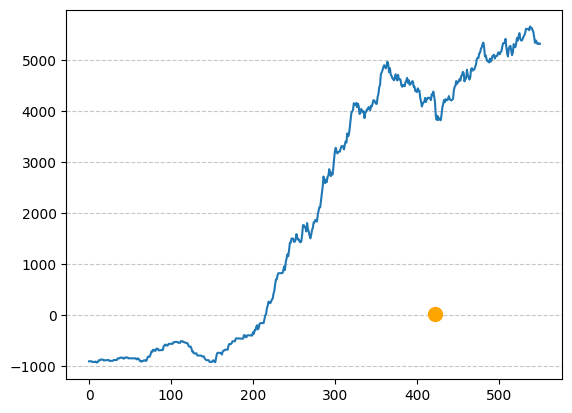

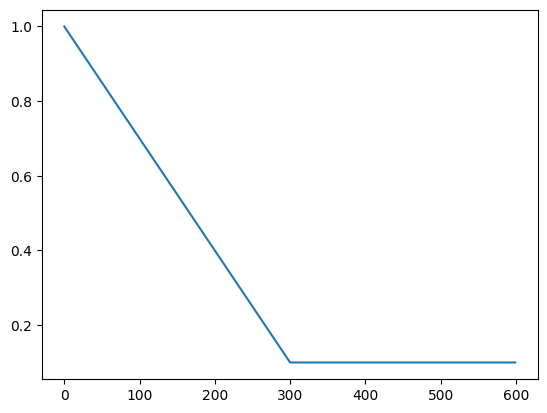

In [10]:
model = torch.nn.Sequential(    torch.nn.Linear(4, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results, epsilons = train(model, epoch=600, gamm=0.99, lrate=0.001)
evaluate_model(model, print_qvals=False, render=False, episodes=10, size=12)

plot_progress(results)
plt.show()
plt.plot(epsilons)

In [69]:
evaluate_model(model, size=20, episodes=100, render=False, print_qvals=False)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_22628\3780120984.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_22628\3780120984.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)


Episode 1: Reward = 15850: Apples got:29
Episode 2: Reward = 17750: Apples got:38
Episode 3: Reward = 15900: Apples got:30
Episode 4: Reward = 27900: Apples got:41
Episode 5: Reward = 21600: Apples got:32
Episode 6: Reward = 23250: Apples got:40
Episode 7: Reward = 20750: Apples got:32
Episode 8: Reward = 22750: Apples got:35
Episode 9: Reward = 21800: Apples got:36
Episode 10: Reward = 15300: Apples got:22
Episode 11: Reward = 17250: Apples got:26
Episode 12: Reward = 24100: Apples got:31
Episode 13: Reward = 17650: Apples got:20
Episode 14: Reward = 11400: Apples got:26
Episode 15: Reward = 24300: Apples got:39
Episode 16: Reward = 26400: Apples got:39
Episode 17: Reward = 18850: Apples got:27
Episode 18: Reward = 16000: Apples got:27
Episode 19: Reward = 22600: Apples got:37
Episode 20: Reward = 22950: Apples got:34
Episode 21: Reward = -200: Apples got:0
Episode 22: Reward = 26300: Apples got:42
Episode 23: Reward = 21400: Apples got:34
Episode 24: Reward = 13800: Apples got:30
Epi

### Trying to make it work with giving the whole map as input

collecting imaegs to train a cnn

In [ ]:
data = []

model = torch.nn.Sequential(    torch.nn.Linear(4, 64),    torch.nn.ReLU(),    torch.nn.Linear(64, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 3))
results1_1, epsilons1, data = train(model, epoch=600, gamm=0.99, lrate=0.001, size=8)
data = evaluate_model(model, size=8, render=False, episodes=500)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17708\3256207844.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17708\3256207844.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)


Episode 1: Reward = 6750: Apples got:19
Episode 2: Reward = -200: Apples got:0
Episode 3: Reward = 3700: Apples got:18
Episode 4: Reward = 5450: Apples got:18
Episode 5: Reward = 4500: Apples got:14
Episode 6: Reward = -200: Apples got:0
Episode 7: Reward = 4300: Apples got:15
Episode 8: Reward = 2200: Apples got:10
Episode 9: Reward = -200: Apples got:0
Episode 10: Reward = 3600: Apples got:12
Episode 11: Reward = 5000: Apples got:13
Episode 12: Reward = 4500: Apples got:13
Episode 13: Reward = 5800: Apples got:14
Episode 14: Reward = 2400: Apples got:11
Episode 15: Reward = 3700: Apples got:10
step limit of 4000 crossed
Episode 16: Reward = -196000: Apples got:4
Episode 17: Reward = 6100: Apples got:18
Episode 18: Reward = 4300: Apples got:14
Episode 19: Reward = 4900: Apples got:16
Episode 20: Reward = 4200: Apples got:15
Episode 21: Reward = 4950: Apples got:16
Episode 22: Reward = 4700: Apples got:14
Episode 23: Reward = 6550: Apples got:18
Episode 24: Reward = 2500: Apples got:10

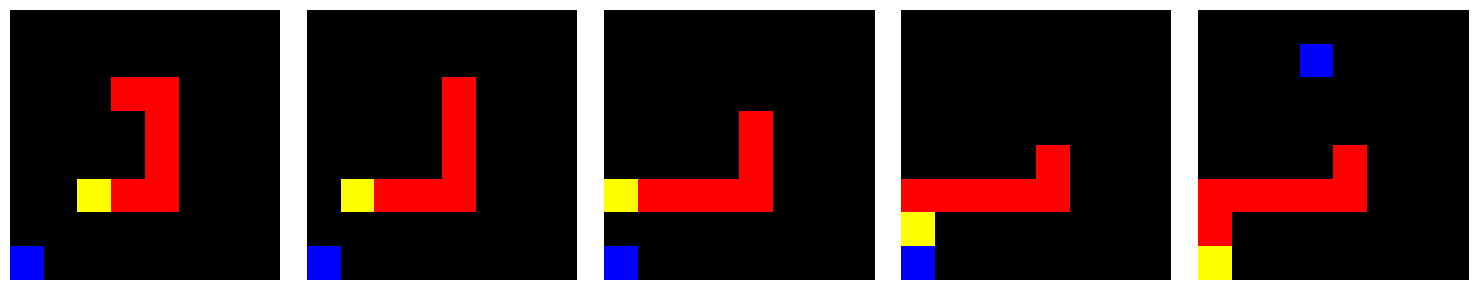

(98902, 3, 8, 8)

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = data[i+30].numpy()  # shape: (3, H, W)
    # Move channel axis to last for matplotlib (H, W, C)
    img_disp = np.transpose(img, (1, 2, 0))
    axes[i].imshow(img_disp)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
np.shape(data)

In [12]:
device = torch.device("cuda")
torch.cuda.is_available()

True

if training is succesfull we will only use the encoder whihc takes a whole image and outputs a small 24 dim vector which has all the iformation abut the state

In [90]:
encoder = torch.nn.Sequential(
    torch.nn.Conv2d(3, 8, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(8, 16, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(16),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(),
    torch.nn.Linear(16 * 4 * 4, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 24),
    torch.nn.BatchNorm1d(24)
)

decoder = torch.nn.Sequential(

    torch.nn.Linear(24, 128),
    torch.nn.ReLU(),

    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),

    torch.nn.Linear(128, 192),
    torch.nn.Sigmoid(),

    torch.nn.Unflatten(1, (3, 8, 8))
)


the model is trained to recreate the images

In [97]:
def train(encoder, decoder, data, epoch=10):
    model_1 = encoder.to(device)
    model_2 = decoder.to(device)

    # optimizer_seq = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer_seq =   torch.optim.Adam(model_1.parameters(), lr=0.001)
    optimizer_seq_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_seq, step_size=30, gamma=0.5)
    scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_seq_2, step_size=30, gamma=0.5)

    data_tensor = torch.stack(data)  # shape: (N, 3, 12, 12)
    train_loader = torch.utils.data.DataLoader(data_tensor, batch_size=128, shuffle=True, pin_memory=True)
    # train_data  = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True, pin_memory=True)

    loss_fn = torch.nn.MSELoss()
    weights = torch.ones((1, 3, 8, 8)).to(device)
    weights[:, 0, :, :] = 1
    weights[:, 1, :, :] = 2
    weights[:, 2, :, :] = 5

    for i in range(epoch):
        model_1.train()
        model_2.train()
        total_loss = 0
        for x in train_loader:
            x = x.to(device)

            optimizer_seq.zero_grad()
            optimizer_seq_2.zero_grad()
            
            neck = model_1(x)
            out = model_2(neck)

            # loss = 100*loss_fn(out[:,2], x[:,2])/3 + 7*loss_fn(out[:,1], x[:,1])/3 + loss_fn(out[:,0], x[:,0])/3
            
            # do not multiply things that just make lr higher
        
            # loss = (loss_fn(out[:,0], x[:,0])  + 20*loss_fn(out[:,1], x[:,1]) + 20*loss_fn(out[:,2], x[:,2]))/40 - torch.sum(out)/(128000)
            
            out = out*weights
            x = x*weights
            # loss = loss_fn(out, x)/5 
            loss = loss_fn(out, x)/8 #- torch.sum(out)/(999000)
        
            loss.backward()
            optimizer_seq.step()
            optimizer_seq_2.step()
            total_loss += loss  
        
        scheduler.step()
        scheduler_2.step()
        if i%1 == 0:
            print(f"Epoch: {i+1}, Loss: {total_loss}") 

In [37]:
def evaluate_cnn():
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    encoder.to(device)
    decoder.to(device)
    
    encoder.eval()
    decoder.eval()
    for i in range(10):
        img = data[i+6100].to(device)  # shape: (3, H, W)
        # Move channel axis to last for matplotlib (H, W, C)
        img_disp = np.transpose(img.cpu().numpy(), (1, 2, 0))
        axes[0][i].imshow(img_disp)
        axes[0][i].axis('off')
        with torch.no_grad():
            out = encoder(img.unsqueeze(0))
            out = decoder(out).squeeze()
            # axes[1][i].imshow(np.transpose(out.cpu().numpy(), (1, 2, 0))[:,:,2])
            axes[1][i].imshow(np.transpose(out.cpu().numpy(), (1, 2, 0)))
            axes[1][i].axis('off')
    plt.tight_layout()
    plt.show()
    np.shape(data)

Epoch: 1, Loss: 16.87636375427246
Epoch: 2, Loss: 5.04104471206665
Epoch: 3, Loss: 3.402724504470825
Epoch: 4, Loss: 2.1624794006347656
Epoch: 5, Loss: 1.2654184103012085
Epoch: 6, Loss: 0.7444584965705872
Epoch: 7, Loss: 0.43840843439102173
Epoch: 8, Loss: 0.24669815599918365
Epoch: 9, Loss: 0.11032357066869736
Epoch: 10, Loss: -0.004977426491677761


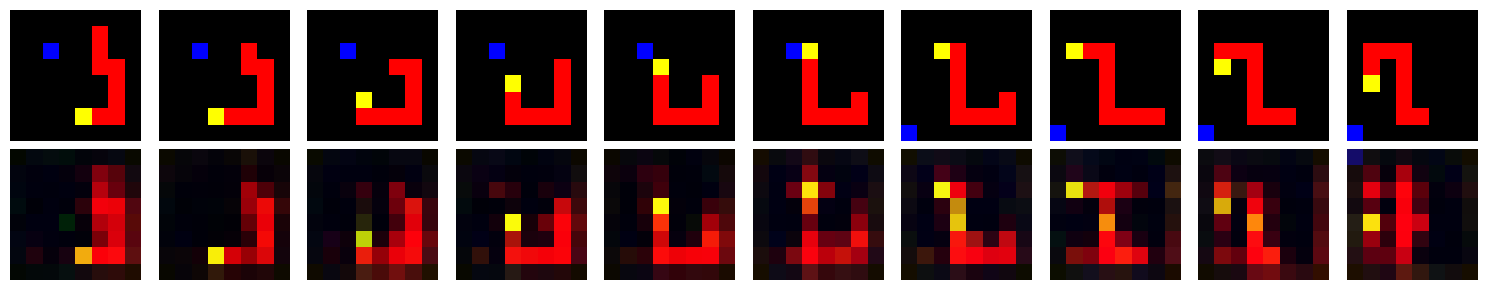

In [91]:
train(encoder, decoder, data, 10)
evaluate_cnn()

10 more epochs after removing the torch.sum(out) from loss

Epoch: 1, Loss: -0.10678286850452423
Epoch: 2, Loss: -0.1869315356016159
Epoch: 3, Loss: -0.2553151249885559
Epoch: 4, Loss: -0.3131040930747986
Epoch: 5, Loss: -0.3605242669582367
Epoch: 6, Loss: -0.4021458327770233
Epoch: 7, Loss: -0.4340718388557434
Epoch: 8, Loss: -0.4636993110179901
Epoch: 9, Loss: -0.49016544222831726
Epoch: 10, Loss: -0.514626681804657


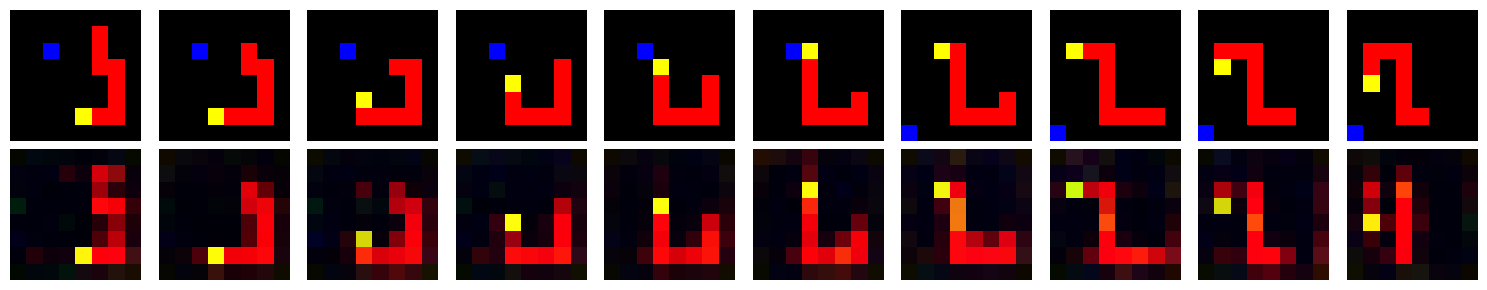

In [92]:
train(encoder, decoder, data, 10)
evaluate_cnn()

changed weights to 1, 2, 5

Epoch: 1, Loss: 5.280642032623291
Epoch: 2, Loss: 4.886704444885254
Epoch: 3, Loss: 3.6835203170776367
Epoch: 4, Loss: 1.684110164642334
Epoch: 5, Loss: 1.2732232809066772
Epoch: 6, Loss: 1.121661901473999
Epoch: 7, Loss: 1.0258855819702148
Epoch: 8, Loss: 0.9583442211151123
Epoch: 9, Loss: 0.90351402759552
Epoch: 10, Loss: 0.8621383905410767


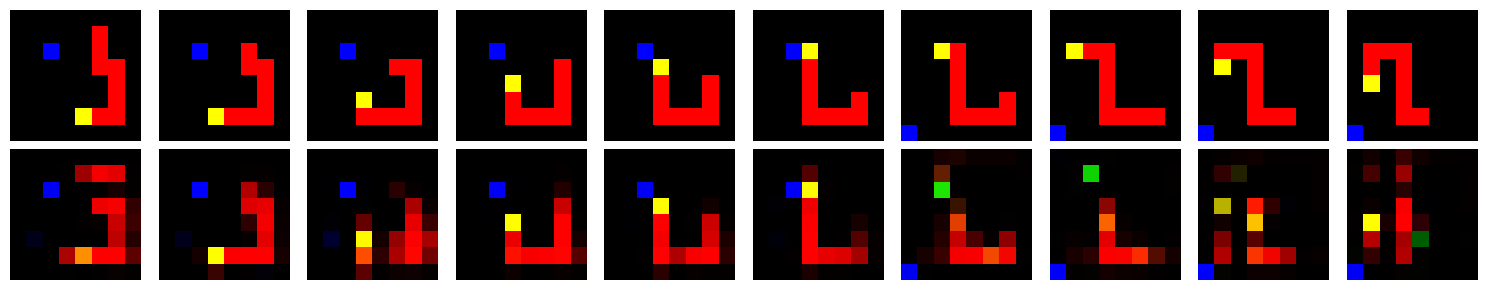

In [95]:
train(encoder, decoder, data, 10)
evaluate_cnn()

Epoch: 1, Loss: 1.1556665897369385
Epoch: 2, Loss: 0.971298098564148
Epoch: 3, Loss: 0.8771467208862305
Epoch: 4, Loss: 0.79844731092453
Epoch: 5, Loss: 0.7466164231300354
Epoch: 6, Loss: 0.6954848766326904
Epoch: 7, Loss: 0.6615048050880432
Epoch: 8, Loss: 0.6265544295310974
Epoch: 9, Loss: 0.5882168412208557
Epoch: 10, Loss: 0.5580672025680542
Epoch: 11, Loss: 0.5328813195228577
Epoch: 12, Loss: 0.49846819043159485
Epoch: 13, Loss: 0.47983402013778687
Epoch: 14, Loss: 0.459163635969162
Epoch: 15, Loss: 0.4339509606361389
Epoch: 16, Loss: 0.4212673604488373
Epoch: 17, Loss: 0.3958342373371124
Epoch: 18, Loss: 0.37889158725738525
Epoch: 19, Loss: 0.36404600739479065
Epoch: 20, Loss: 0.3508519232273102
Epoch: 21, Loss: 0.3421275317668915
Epoch: 22, Loss: 0.32566291093826294
Epoch: 23, Loss: 0.3178091049194336
Epoch: 24, Loss: 0.31082507967948914
Epoch: 25, Loss: 0.2957438826560974
Epoch: 26, Loss: 0.28859803080558777
Epoch: 27, Loss: 0.2855386435985565
Epoch: 28, Loss: 0.274005115032196

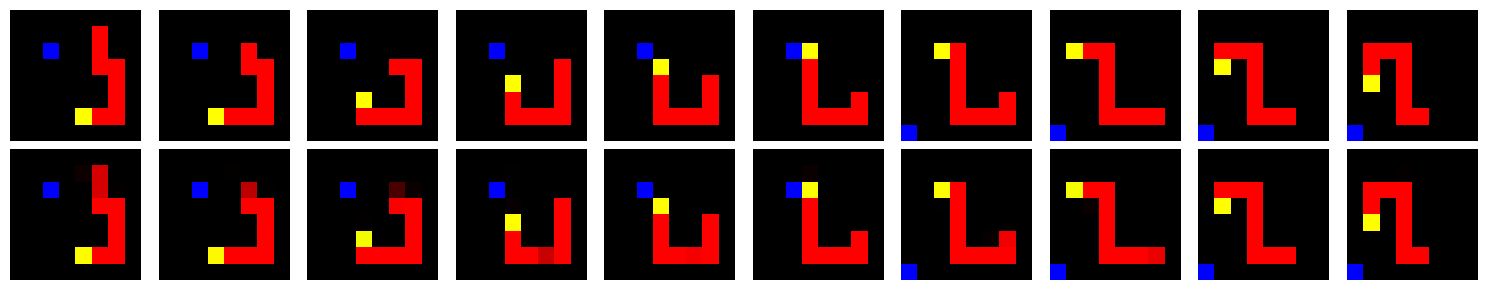

In [98]:
train(encoder, decoder, data, 100)
evaluate_cnn()

In [99]:
torch.save(encoder.state_dict(), "encoder")
torch.save(decoder.state_dict(), "decoder")

In [134]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(24, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 192),
    torch.nn.Sigmoid(),
    torch.nn.Unflatten(1, (3, 8, 8))
)
decoder.load_state_dict(torch.load("decoder"))
decoder.eval()

Sequential(
  (0): Linear(in_features=24, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=192, bias=True)
  (5): Sigmoid()
  (6): Unflatten(dim=1, unflattened_size=(3, 8, 8))
)

In [ ]:
encoder = torch.nn.Sequential(
    torch.nn.Conv2d(3, 8, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(8, 16, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(16),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(),
    torch.nn.Linear(16 * 4 * 4, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 24),
    torch.nn.BatchNorm1d(24)
)
encoder.load_state_dict(torch.load("encoder"))
encoder.eval()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=24, bias=True)
  (12): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

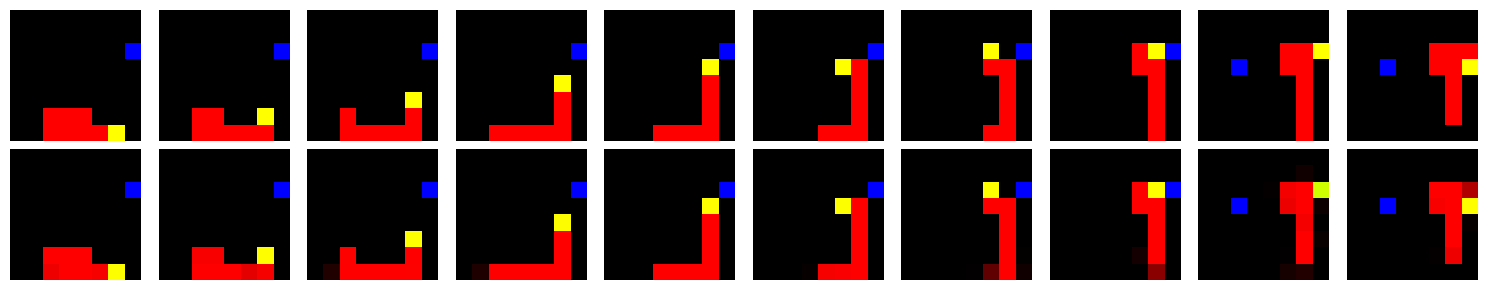

(98902, 3, 8, 8)

In [135]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
# encoder.to(device)
# decoder.to(device)

encoder.eval()
decoder.eval()
for i in range(10):
    img = data[i+5890]  # shape: (3, H, W)
    # Move channel axis to last for matplotlib (H, W, C)
    img_disp = np.transpose(img.cpu().numpy(), (1, 2, 0))
    axes[0][i].imshow(img_disp)
    axes[0][i].axis('off')
    with torch.no_grad():
        out = encoder(img.unsqueeze(0))
        out = decoder(out).squeeze()
        # axes[1][i].imshow(np.transpose(out.cpu().numpy(), (1, 2, 0))[:,:,2])
        axes[1][i].imshow(np.transpose(out.cpu().numpy(), (1, 2, 0)))
        axes[1][i].axis('off')
plt.tight_layout()
plt.show()
np.shape(data)

### Training DQN with obs from the encoder nn

In [236]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class snake_ExperienceBuffer_2:
    def __init__(self, capacity, map_size):

        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 28), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 28), dtype=torch.float)

        # total samples collected
        self.occupied = 0

        self.cap = capacity

    
    def push(self, state, action, reward, next_state, done):  
        
        if self.occupied < self.cap:
            index = self.occupied
        else:
            # after being filled replacing randomly
            index = np.random.randint(low =0, high=self.occupied)

        self.buffer[index][0] = reward
        self.buffer[index][1] = done

        self.actions[index] = action
        self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
        
        self.occupied += 1
        self.occupied = min(self.occupied, self.cap)

    def sample(self, batch_size):

        batch = torch.randint(0, self.occupied, size=(batch_size,))

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):
        
        return self.occupied >= batch 



In [239]:
# TODO: Implement training logic for Snake Game here

import copy


def train_with_encoder(model, epoch=1000, gamm=0.99, size=8, rend=False, lrate=0.001):

    if rend:
        env = SnakeGame(size, render_mode="human")
    else:
        env = SnakeGame(size)

    q_net = model
    target_net = copy.deepcopy(q_net)

    replay_buffer = snake_ExperienceBuffer_2(10000, size)
    # temp_buffer = []

    epochs = epoch
    epsilon = 1
    batch_size = 64
    gamma = gamm
    # loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=lrate)

    results = np.zeros(epochs)
    epsilons = np.zeros(epochs)

    steps_till_update = 0
    step_count = 0
    for i in tqdm.tqdm(range(epochs)):

        state = env.reset()[0]

        encoded_obs = torch.zeros(28)
        next_encoded_obs = torch.zeros(28)
        
        encoded_obs[0:24] = encoder(state[0].unsqueeze(0))
        encoded_obs[24:28] = state[1]

        done = False
        total_reward = 0
        step_count = 0

        while not done:

            optimizer_seq.zero_grad()

            # selecting next action
            if np.random.rand() < epsilon and not torch.sum(encoded_obs[24:27] == -1):
                action = np.random.randint(0, 4)
                greedy = True
            else:
                with torch.no_grad():
                    action = torch.argmax(q_net(encoded_obs))
                greedy = False

            next_state, reward, done, _, _ = env.step(int(action))

            next_encoded_obs[:24] = encoder(next_state[0].unsqueeze(0))
            next_encoded_obs[24:28] = next_state[1]

            if (not greedy) or epsilon > 0:
                replay_buffer.push(encoded_obs, action, reward, next_encoded_obs, done)

            total_reward += reward
            steps_till_update += 1
            step_count += 1
            state = next_state
            encoded_obs = next_encoded_obs

            if replay_buffer.filled(batch_size):
            
                data, actions, states, next_states = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    # next_action = torch.zeros(size=(batch_size, 1), dtype=torch.int64)
                    # for i in range(batch_size):
                    #     next_action[i, 0] = int(np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(target_net(next_states[i].unsqueeze(0)).reshape(4,), dim=0).numpy()))
                    # targets = data[:, 0] + gamma*target_net.forward(next_states).gather(1, next_actions)*(1-data[:, 1])
                    # print("target_net(next_states) shape:", target_net(next_states).shape)
                    targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

                loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10)
                optimizer_seq.step()


            # updating target net
            if steps_till_update == 100:
            # if steps_till_update == max(i, 50):
                steps_till_update = 0
                target_net = copy.deepcopy(q_net)

            if total_reward <= -1000:
                done = True

        # n = len(temp_buffer)
        # if n > 0:
        #     probs = np.arange(1, n+1)
        #     probs = probs/probs.sum()  # Normalize to sum to 1
        #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
        #         replay_buffer.push(*temp_buffer[j])

        # temp_buffer = []

        # if epsilon > 0:
        #     epsilon = max(0, 1-i*1/(epoch/2))
        if epsilon > 0.2:
            epsilon = max(0.2, 1-i*0.8/(epoch/2))

        results[i] = total_reward
        epsilons[i] = epsilon
        total_reward = 0

    return results, epsilons


In [226]:
import time

def evaluate_encoder_model(model, size=8, episodes=10, render=True, epsil = 0, wait=False, print_qvals=False):
    env = SnakeGame(size=size, render_mode="human" if render else None)
    model.eval()

    rewards = []
    counts = []

    # time.sleep(3)
    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        encoded_obs = torch.zeros(28)
        next_encoded_obs = torch.zeros(28)

        encoded_obs[0:24] = encoder(obs[0].unsqueeze(0))
        encoded_obs[24:28] = obs[1]
        
        count = 0
        steps = 0

        while not done:

            # selecting next action
            with torch.no_grad():
                action = torch.argmax(model(encoded_obs))

            next_state, reward, done, _, _ = env.step(int(action))

            next_encoded_obs[0:24] = encoder(next_state[0].unsqueeze(0))
            next_encoded_obs[24:28] = next_state[1]

            total_reward += reward
            steps += 1
            state = next_state
            encoded_obs = next_encoded_obs
            count = len(env.snake) - 1
            
            with torch.no_grad():
                if print_qvals:
                    print(model(encoded_obs))


            # np.argsort(q_values)
            # for i in range(size+2):
            #     for j in range(size+2):
            #         print(obs[0][i][j], end="")
            #     print()
            # print(obs)



            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"straight: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            # print()
            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"up: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            # print()
            
            waiting = wait
            while waiting:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_n:
                            waiting = False
                        if event.key == pygame.K_ESCAPE:
                            done = True
                            waiting = False

            steps += 1
            if total_reward <= -1000:
                done = True
                print("stuck")
            # print(total_reward)
            # if render:
                # env.render()
    
        rewards.append(total_reward)
        counts.append(count)
        print(f"Episode {episode + 1}: Reward = {total_reward}: Apples got:{count}")

    env.close()
    avg_reward = sum(rewards) / episodes
    avg_count = np.mean(counts)

    print(f"Average reward over {episodes} episodes: {avg_reward}")
    print(f"Average apples over {episodes} episodes: {avg_count}")

In [240]:
snake_QN = torch.nn.Sequential(

    torch.nn.Linear(28, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 12),
    torch.nn.ReLU(),
    torch.nn.Linear(12, 4)
    
)

In [243]:
evaluate_encoder_model(snake_QN, size=8, episodes=10, render=True, print_qvals=False)

stuck
Episode 1: Reward = -1100: Apples got:0
stuck
Episode 2: Reward = -1000: Apples got:0
stuck
Episode 3: Reward = -1050: Apples got:0
stuck
Episode 4: Reward = -1100: Apples got:1
stuck
Episode 5: Reward = -1050: Apples got:0
Episode 6: Reward = -600: Apples got:1
Episode 7: Reward = -350: Apples got:0
stuck
Episode 8: Reward = -1050: Apples got:0
Episode 9: Reward = -300: Apples got:0


KeyboardInterrupt: 

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17708\1035974977.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17708\1035974977.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 10000/10000 [05:20<00:00, 31.20it/s]

Best run: 650.0, at episode: 9654


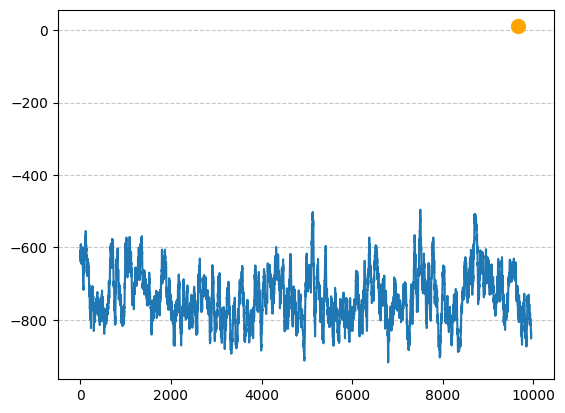

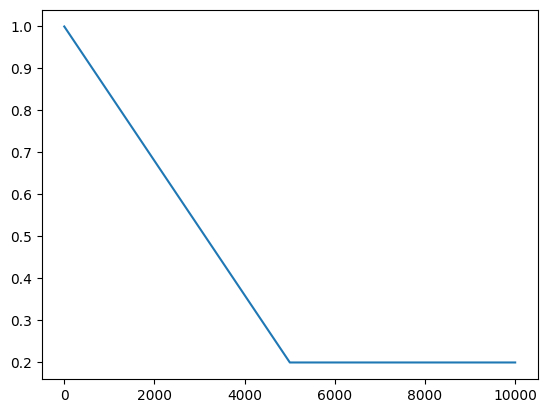

In [241]:
results, epsilons = train_with_encoder(snake_QN, epoch=10000, gamm=0.99, lrate=0.001)
plot_progress(results)
plt.show()
plt.plot(epsilons)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17708\260304885.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17708\260304885.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 5000/5000 [04:13<00:00, 19.74it/s]

Best run: 1750.0, at episode: 4599


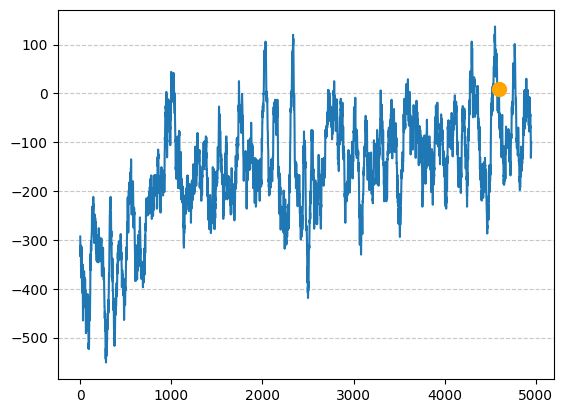

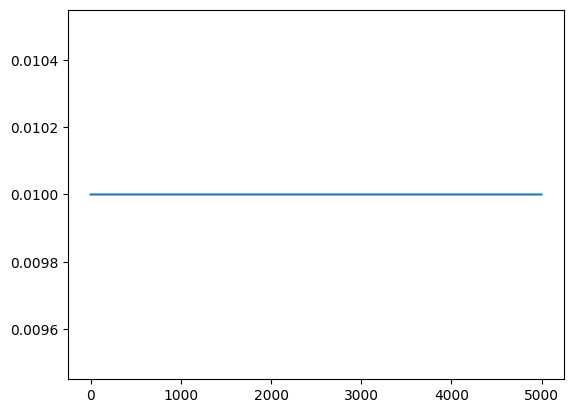

In [215]:
results, epsilons = train_with_encoder(snake_QN, epoch=5000, gamm=0.99, lrate=0.001)
plot_progress(results)
plt.show()
plt.plot(epsilons)